Please keep these in mind:

1. Can you explain the core concept behind PINNs?

2. Can you state how PINNs differ from traditional neural networks?

3. Can you describe the role of governing equations in PINNs?

4. How are the equations incorporated into the neural network (NN) architecture?  (Changed "are" to "are" for subject-verb agreement)

5. Can you connect PINNs to practical applications? Can you give an example of a scientific or engineering problem that could be solved using PINNs?  

6. Can you see the advantages of using PINNs compared to traditional methods for solving physical problems?


# 1-D model

## Model using tensorflow backend

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [ ]:

def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

Please write here the ODE system using Latex processing:

$
\frac{du}{dt} = \cos{2\pi t}
$

$
u(0)=1
$

In [ ]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    #tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                64        
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1.8806313
0.00032431164
0.00018754393
0.00043204
9.8410834e-05
7.217471e-05
5.5489294e-05
4.6179106e-05
7.930037e-05


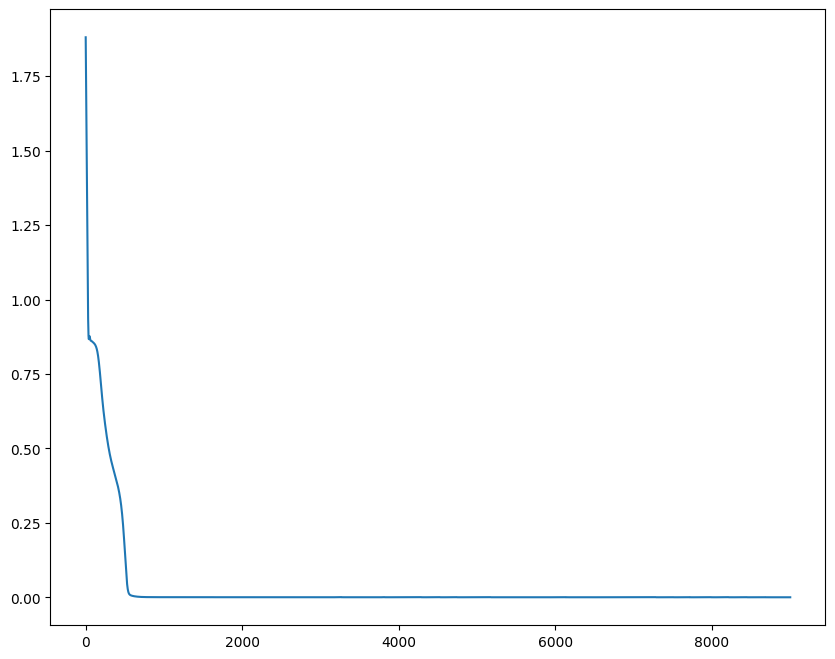

In [ ]:
train_t = (np.array([0., 0.025, 0.475, 0.5, 0.525, 0.9, 0.95, 1., 1.05, 1.1, 1.4, 1.45, 1.5, 1.55, 1.6, 1.95, 2.])).reshape(-1, 1)
train_loss_record = []


for itr in range(5000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

4/4 [==============================] - 0s 2ms/step


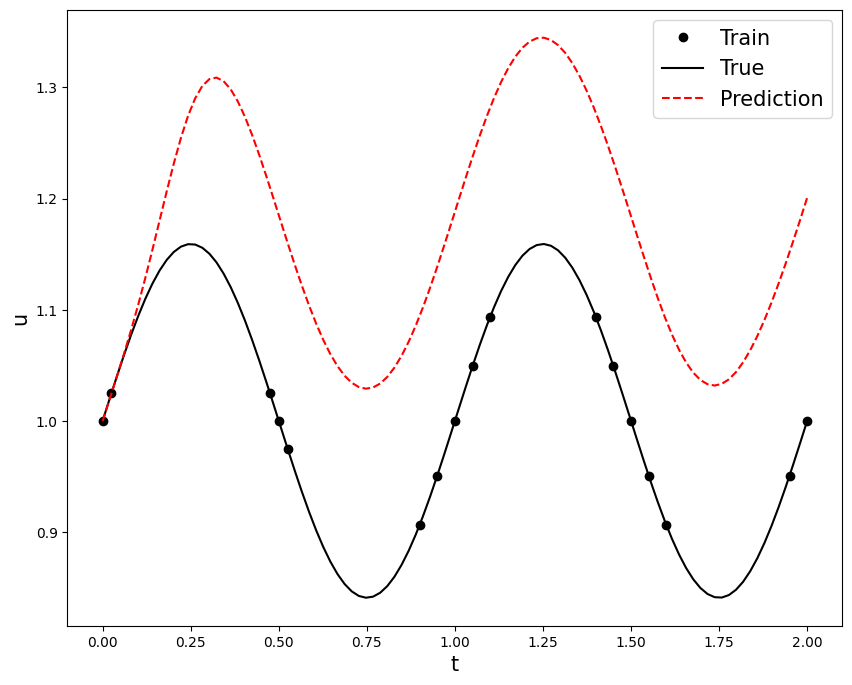

In [ ]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

## Model using DeepXDE backend

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import math as m

pi = tf.constant(m.pi)

In [ ]:
def ode_system(t, u):
    du_t = dde.grad.jacobian(u, t)
    return du_t - tf.math.cos(2*pi*t)

def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)



In [ ]:
geom = dde.geometry.TimeDomain(0, 2)

ic = dde.IC(geom, lambda t: 1, boundary)

In [ ]:
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

data = dde.data.PDE(geom,
                    ode_system,
                    ic,
                    num_domain = 30,
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

layer_size = [1] + [32] + [1]
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

Compiling model...
Building feed-forward neural network...
'build' took 0.048798 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.344710 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.41e-01, 1.00e+00]    [5.27e-01, 1.00e+00]    []  
1000      [4.48e-01, 1.04e-04]    [4.53e-01, 1.04e-04]    []  
2000      [2.40e-01, 7.26e-07]    [2.52e-01, 7.26e-07]    []  
3000      [1.29e-01, 2.13e-06]    [1.38e-01, 2.13e-06]    []  
4000      [1.38e-02, 2.32e-08]    [1.62e-02, 2.32e-08]    []  
5000      [4.30e-03, 3.25e-09]    [3.85e-03, 3.25e-09]    []  
6000      [3.53e-03, 3.95e-07]    [2.80e-03, 3.95e-07]    []  
7000      [2.88e-03, 1.97e-07]    [2.18e-03, 1.97e-07]    []  
8000      [2.25e-03, 6.00e-11]    [1.65e-03, 6.00e-11]    []  
9000      [1.84e-03, 3.16e-07]    [1.37e-03, 3.16e-07]    []  

Best model at step 9000:
  train loss: 1.84e-03
  test loss: 1.37e-03
  test metric: []

'train' took 5.824843 s



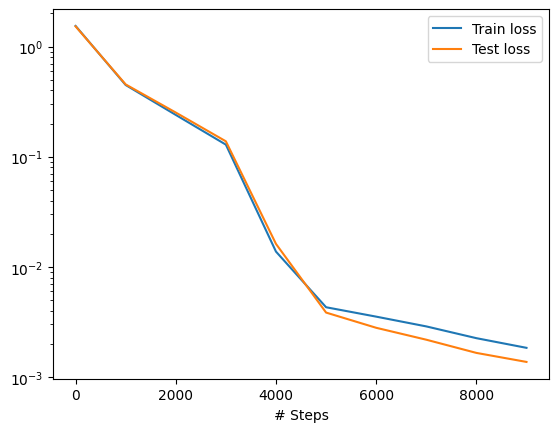

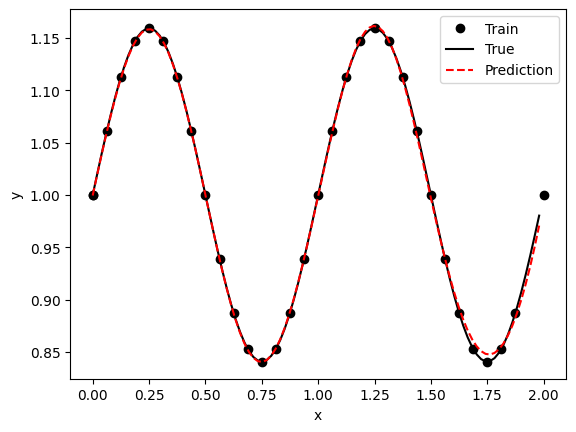

In [ ]:
model = dde.Model(data, NN)
model.compile("adam", lr = 0.001)

losshistory, train_state = model.train(epochs = 9000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)